<a href="https://colab.research.google.com/github/mileslilly2/code_for_whatever_you_are/blob/main/gif_animation_in_Python_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install the stuff

In [ ]:
# ! ⬅ leave the leading bang so it runs in a bash cell
!apt-get update -qq && apt-get install -y -qq ffmpeg
!pip install -q geopandas pyarrow matplotlib imageio imageio-ffmpeg tqdm

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
import imageio.v2 as imageio             # PNG → GIF/MP4
from tqdm.auto import tqdm                # progress bar
from pathlib import Path, PurePath

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["savefig.dpi"]   = 300


download the data,inmport it as a table and then grab the cols we need ands store it in wv

In [ ]:
ers_url = ("https://ers.usda.gov/sites/default/files/_laserfiche/"
           "DataFiles/48747/Unemployment2023.csv?v=84954")



In [ ]:
ers_url

'https://ers.usda.gov/sites/default/files/_laserfiche/DataFiles/48747/Unemployment2023.csv?v=84954'

In [ ]:

ers = pd.read_csv(ers_url, dtype=str)


In [ ]:
ers.head()

,FIPS_Code,State,Area_Name,Attribute,Value
0,0,US,United States,Civilian_labor_force_2000,142601576
1,0,US,United States,Employed_2000,136904853
2,0,US,United States,Unemployed_2000,5696723
3,0,US,United States,Unemployment_rate_2000,4
4,0,US,United States,Civilian_labor_force_2001,143786537


In [ ]:
ers.tail()

,FIPS_Code,State,Area_Name,Attribute,Value
329721,72153,PR,"Yauco Municipio, PR",Unemployment_rate_2022,10.3
329722,72153,PR,"Yauco Municipio, PR",Civilian_labor_force_2023,10488
329723,72153,PR,"Yauco Municipio, PR",Employed_2023,9278
329724,72153,PR,"Yauco Municipio, PR",Unemployed_2023,1210
329725,72153,PR,"Yauco Municipio, PR",Unemployment_rate_2023,11.5


In [ ]:
wv_long = (
    ers[ers["State"] == "WV"]
       .query("Attribute.str.contains(r'_\\d{4}$')", engine="python")
       .copy()
)


In [ ]:
wv_long

,FIPS_Code,State,Area_Name,Attribute,Value
306780,54000,WV,West Virginia,Civilian_labor_force_2000,799081
306781,54000,WV,West Virginia,Employed_2000,754457
306782,54000,WV,West Virginia,Unemployed_2000,44624
306783,54000,WV,West Virginia,Unemployment_rate_2000,5.6
306784,54000,WV,West Virginia,Civilian_labor_force_2001,796596
...,...,...,...,...,...
312428,54109,WV,"Wyoming County, WV",Employed_2023,6923
312429,54109,WV,"Wyoming County, WV",Unemployed_2023,310
312430,54109,WV,"Wyoming County, WV",Unemployment_rate_2023,4.3
312431,54109,WV,"Wyoming County, WV",Median_Household_Income_2022,39892


In [ ]:

# ── 2.  Split Attribute → indicator + year
wv_long["Year"]      = wv_long["Attribute"].str.extract(r"_(\d{4})$").astype(int)
wv_long["Indicator"] = wv_long["Attribute"].str.extract(r'^(.*)_\d{4}')[0]



In [ ]:
wv_long.head()

,FIPS_Code,State,Area_Name,Attribute,Value,Year,Indicator
306780,54000,WV,West Virginia,Civilian_labor_force_2000,799081,2000,Civilian_labor_force
306781,54000,WV,West Virginia,Employed_2000,754457,2000,Employed
306782,54000,WV,West Virginia,Unemployed_2000,44624,2000,Unemployed
306783,54000,WV,West Virginia,Unemployment_rate_2000,5.6,2000,Unemployment_rate
306784,54000,WV,West Virginia,Civilian_labor_force_2001,796596,2001,Civilian_labor_force


In [ ]:
wv_long = wv_long.rename(columns={"FIPS_Code": "FIPS"})


In [ ]:
wv_long.head()

,FIPS,State,Area_Name,Attribute,Value,Year,Indicator
306780,54000,WV,West Virginia,Civilian_labor_force_2000,799081,2000,Civilian_labor_force
306781,54000,WV,West Virginia,Employed_2000,754457,2000,Employed
306782,54000,WV,West Virginia,Unemployed_2000,44624,2000,Unemployed
306783,54000,WV,West Virginia,Unemployment_rate_2000,5.6,2000,Unemployment_rate
306784,54000,WV,West Virginia,Civilian_labor_force_2001,796596,2001,Civilian_labor_force


In [ ]:

# ── 4.  Pivot wider so each indicator becomes a column
wv = (wv_long
        .pivot_table(index=["FIPS", "Area_Name", "Year"],
                     columns="Indicator",
                     values="Value",
                     aggfunc="first")
        .reset_index())



In [ ]:
wv.head()

Indicator,FIPS,Area_Name,Year,Civilian_labor_force,Employed,Med_HH_Income_Percent_of_State_Total,Median_Household_Income,Metro,Rural_Urban_Continuum_Code,Unemployed,Unemployment_rate,Urban_Influence_Code
0,54000,West Virginia,2000,799081,754457,NaN,NaN,NaN,NaN,44624,5.6,NaN
1,54000,West Virginia,2001,796596,753657,NaN,NaN,NaN,NaN,42939,5.4,NaN
2,54000,West Virginia,2002,798709,747040,NaN,NaN,NaN,NaN,51669,6.5,NaN
3,54000,West Virginia,2003,791841,739896,NaN,NaN,NaN,NaN,51945,6.6,NaN
4,54000,West Virginia,2004,789527,743989,NaN,NaN,NaN,NaN,45538,5.8,NaN


In [ ]:
# ── 5.  Keep just the four labor-force columns
keep = ["FIPS", "Area_Name", "Year",
        "Civilian_labor_force", "Employed",
        "Unemployed", "Unemployment_rate"]

wv = wv[keep].sort_values(["FIPS", "Year"]).reset_index(drop=True)



In [ ]:
wv.head()

Indicator,FIPS,Area_Name,Year,Civilian_labor_force,Employed,Unemployed,Unemployment_rate
0,54000,West Virginia,2000,799081,754457,44624,5.6
1,54000,West Virginia,2001,796596,753657,42939,5.4
2,54000,West Virginia,2002,798709,747040,51669,6.5
3,54000,West Virginia,2003,791841,739896,51945,6.6
4,54000,West Virginia,2004,789527,743989,45538,5.8


If you want to see all the unique attributes

In [ ]:
import geopandas as gpd

url = ("https://data.wvgis.wvu.edu/pub/Clearinghouse/Boundaries/"
       "County_Boundaries_24K_Topo/"
       "WV_county_boundaries_24k_topo_updated_2022_utm83.zip")

gdf = (gpd
       .read_file(f"zip+{url}")   # GDAL’s vsizip + vsicurl
       .to_crs(4326)              # reproject to WGS-84
)


In [ ]:
gdf.head()

,Shape_Leng,Shape_Area,County_Nam,Area_Acres,Area_Sq_Mi,Perimeter_,geometry
0,189421.563714,1.477442e+09,BARBOUR,219362.817685,342.754403,481807.757303,"POLYGON ((-79.89178 39.2989, -79.89072 39.2988..."
1,202046.975967,1.398883e+09,BERKELEY,205758.751095,321.498049,511280.202162,"POLYGON ((-78.02471 39.62058, -78.02468 39.620..."
2,329563.713475,2.103672e+09,BOONE,322063.488362,503.224201,851108.585338,"POLYGON ((-81.77948 38.23066, -81.77932 38.230..."
3,221424.016676,2.200189e+09,BRAXTON,330649.253335,516.639458,566519.536892,"POLYGON ((-80.60511 38.90359, -80.60332 38.901..."
4,103997.616510,4.132996e+08,BROOKE,59383.945388,92.787415,260033.764928,"POLYGON ((-80.51905 40.39879, -80.519 40.3964,..."


lets look at all the colors to vis our data

interlude

In [ ]:
import matplotlib.pyplot as plt

print(plt.colormaps())


['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'berlin', 'managua', 'vanimo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 't

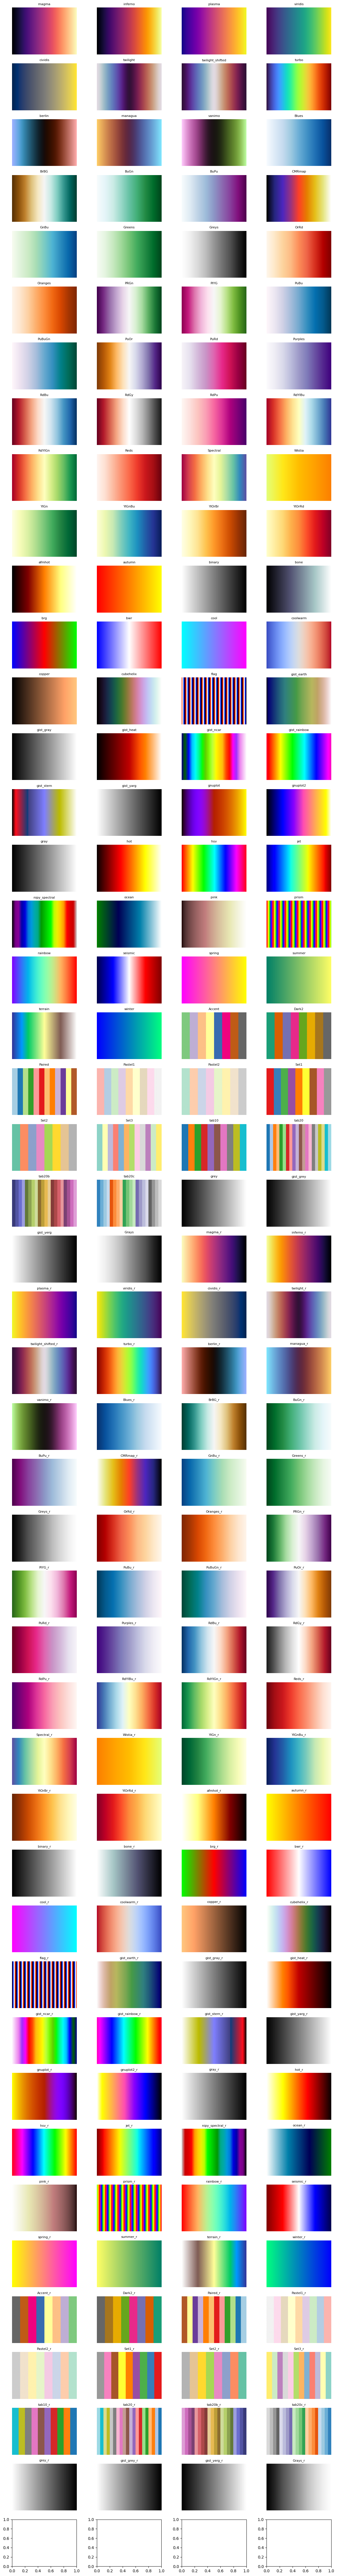

In [ ]:
import matplotlib.pyplot as plt

cmaps = plt.colormaps()
n = len(cmaps)
fig, axs = plt.subplots(nrows=(n // 4) + 1, ncols=4, figsize=(12, n // 2))
for i, cmap_name in enumerate(cmaps):
    ax = axs.flat[i]
    gradient = [list(range(256))] * 2
    ax.imshow(gradient, aspect='auto', cmap=plt.colormaps[cmap_name])
    ax.set_title(cmap_name, fontsize=8)
    ax.set_axis_off()
plt.tight_layout()
plt.show()


third seq

In [ ]:
out_dir = Path("frames")
out_dir.mkdir(exist_ok=True)
years = sorted(wv["Year"].unique())

In [ ]:
years

[np.int64(2000),
 np.int64(2001),
 np.int64(2002),
 np.int64(2003),
 np.int64(2004),
 np.int64(2005),
 np.int64(2006),
 np.int64(2007),
 np.int64(2008),
 np.int64(2009),
 np.int64(2010),
 np.int64(2011),
 np.int64(2012),
 np.int64(2013),
 np.int64(2014),
 np.int64(2015),
 np.int64(2016),
 np.int64(2017),
 np.int64(2018),
 np.int64(2019),
 np.int64(2020),
 np.int64(2021),
 np.int64(2022),
 np.int64(2023)]

In [ ]:
cmap = plt.colormaps["Reds"]    # or "OrRd", "Purples", etc.

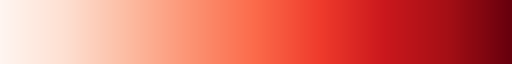

In [ ]:
cmap

In [ ]:

# Before your loop, create a county name merge key in both DataFrames:

# In wv: Create uppercase county name (no 'County, WV')
wv["County_Nam"] = (
    wv["Area_Name"]
      .str.replace(r"\s+County,?\s*WV$", "", regex=True)
      .str.upper()
)



In [ ]:
wv.head()

Indicator,FIPS,Area_Name,Year,Civilian_labor_force,Employed,Unemployed,Unemployment_rate,County_Nam
0,54000,West Virginia,2000,799081,754457,44624,5.6,WEST VIRGINIA
1,54000,West Virginia,2001,796596,753657,42939,5.4,WEST VIRGINIA
2,54000,West Virginia,2002,798709,747040,51669,6.5,WEST VIRGINIA
3,54000,West Virginia,2003,791841,739896,51945,6.6,WEST VIRGINIA
4,54000,West Virginia,2004,789527,743989,45538,5.8,WEST VIRGINIA


In [ ]:
# Your shapefile GeoDataFrame already has gdf["County_Nam"] in uppercase.

# If you filtered out statewide (FIPS == '54000'), do:

wv_county = wv[wv["FIPS"] != "54000"].copy()


In [ ]:
wv_county

Indicator,FIPS,Area_Name,Year,Civilian_labor_force,Employed,Unemployed,Unemployment_rate,County_Nam
24,54001,"Barbour County, WV",2000,6587,6056,531,8.1,BARBOUR
25,54001,"Barbour County, WV",2001,6657,6191,466,7,BARBOUR
26,54001,"Barbour County, WV",2002,6788,6251,537,7.9,BARBOUR
27,54001,"Barbour County, WV",2003,6722,6195,527,7.8,BARBOUR
28,54001,"Barbour County, WV",2004,6579,6122,457,6.9,BARBOUR
...,...,...,...,...,...,...,...,...
1339,54109,"Wyoming County, WV",2019,6652,6184,468,7,WYOMING
1340,54109,"Wyoming County, WV",2020,6779,6112,667,9.8,WYOMING
1341,54109,"Wyoming County, WV",2021,6934,6521,413,6,WYOMING
1342,54109,"Wyoming County, WV",2022,7101,6794,307,4.3,WYOMING


In [ ]:
# after you slice out wv_county...
wv_county["Unemployment_rate"] = pd.to_numeric(
    wv_county["Unemployment_rate"],
    errors="coerce"
)

In [ ]:
wv_county.head()

Indicator,FIPS,Area_Name,Year,Civilian_labor_force,Employed,Unemployed,Unemployment_rate,County_Nam
24,54001,"Barbour County, WV",2000,6587,6056,531,8.1,BARBOUR
25,54001,"Barbour County, WV",2001,6657,6191,466,7.0,BARBOUR
26,54001,"Barbour County, WV",2002,6788,6251,537,7.9,BARBOUR
27,54001,"Barbour County, WV",2003,6722,6195,527,7.8,BARBOUR
28,54001,"Barbour County, WV",2004,6579,6122,457,6.9,BARBOUR


In [ ]:
# After you ensure Unemployment_rate is float
all_vals = wv_county["Unemployment_rate"].dropna()
global_norm = plt.Normalize(vmin=all_vals.min(), vmax=all_vals.max())


# Set up years and normalization as before
years = sorted(wv_county["Year"].unique())


print("Fixed color scale:", all_vals.min(), "to", all_vals.max())
print(f"📆 Years range: {years[0]} to {years[-1]} ({len(years)} total)")
print(f"📊 Total data points: {len(all_vals)} non-null unemployment rates")



Fixed color scale: 2.5 to 15.9
📆 Years range: 2000 to 2023 (24 total)
📊 Total data points: 1320 non-null unemployment rates
📊 The global norm is: <matplotlib.colors.Normalize object at 0x7a3a55daf150>


In [ ]:
cmap = plt.colormaps["Reds"]

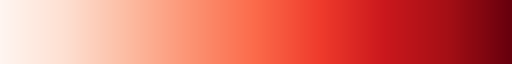

In [ ]:
cmap

In [ ]:

out_dir = Path("frames")
out_dir.mkdir(exist_ok=True)
print(f"📊 Total data points: {len(all_vals)} non-null unemployment rates")

📊 Total data points: 1320 non-null unemployment rates


In [ ]:


for yr in tqdm(years, desc="Rendering frames"):

    this_year = wv_county[wv_county["Year"] == yr]
    vals = this_year["Unemployment_rate"].dropna()
    if len(vals) == 0 or vals.min() == vals.max():
      print(f"⚠️ Skipping year {yr} (no data or constant values)")
      continue

    fig, ax = plt.subplots()
    frame = gdf.merge(this_year, on="County_Nam", how="left")
    frame.plot(
        column="Unemployment_rate",
        cmap=cmap,
        linewidth=0.1,
        edgecolor="0.3",
        norm=global_norm,
        ax=ax,
        legend=True,
        legend_kwds={
            'label': "Unemployment Rate (%)",
            'shrink': 0.6,
            'orientation': "vertical"
        }
    )
    ax.set_axis_off()
    ax.set_title(f"WV County Unemployment – {yr}", fontsize=16, weight="bold")
    img_path = out_dir / f"frame_{yr}.png"
    plt.tight_layout()
    plt.savefig(img_path)
    plt.close(fig)





Fixed color scale: 2.5 to 15.9


Rendering frames:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
from pathlib import Path
frames_dir = Path("frames")
assert frames_dir.exists() and any(frames_dir.glob("frame_*.png")), "No frames found!"


In [ ]:
import imageio.v2 as imageio
png_paths = sorted(frames_dir.glob("frame_*.png"))   # chronological

# read into memory
frames = [imageio.imread(p) for p in png_paths]

# 4 fps → ~6 s total (24 years × 4 fps = 6 s)
imageio.mimsave("wv_unemp.gif", frames, fps=4)
print("GIF written:", Path('wv_unemp.gif').stat().st_size/1e6, "MB")


GIF written: 2.572869 MB


In [ ]:
from pathlib import Path
import imageio.v2 as imageio        # imageio-ffmpeg is auto-installed
from tqdm.auto import tqdm

# 1. Point to your directory of PNG frames
frames_dir = Path("frames")
png_paths  = sorted(frames_dir.glob("frame_*.png"))  # chronological order

# 2. Create a 1080×1920 (or 1080×1080) MP4 at 12 fps
writer = imageio.get_writer(
    "wv_unemp.mp4",
    fps     = 24,             # Instagram Reel looks smooth at 12-24 fps
    codec   = "libx264",
    bitrate = "6M",           # higher = sharper
    ffmpeg_log_level="error"
)

for p in tqdm(png_paths, desc="Stitching MP4"):
    writer.append_data(imageio.imread(p))

writer.close()
size_mb = Path("wv_unemp.mp4").stat().st_size / 1e6
print(f"✅ MP4 written: {size_mb:.2f} MB")



Stitching MP4:   0%|          | 0/24 [00:00<?, ?it/s]

✅ MP4 written: 0.65 MB
